## Sections

[Problem](#Problem)  
[Exploratory analysis](#Exploratory-analysis)  
[Feature engineering](#Feature-engineering)

- [Drop old data](#Drop-old)
- [Identify major powers](#Major-powers)
- [Merge pairs](#Merge-pairs)
- [Incorprate prior disputes](#Prior-disputes)
- [Calculate power ratios](#Power-ratios)
- [Incorporate contiguity](#Contiguity)
- [Build data set](#Build-data-set)

[Modeling](#Modeling)

- [Helper functions](#Helper-functions)
- [Prepare training data set](#Prepare-training-data-set)
- [Try all algorithms](#Try-all-algorithms)
- [Tune hyperparameters](#Tune-hyperparameters)

    - [KNN](#KNN)
    - [Logistic regression](#Logistic-regression)
    - [LinearSCV](#LinearSVC)
    - [Random forest](#Random-forest)
- [The final model](#The-final-model)
- [Top features](#Top-features)
- [Save the model](#Save-the-model)

[Citations](#Citations)  
[Scratchpad](#Scratchpad)


## Problem
[[back to top]](#Sections)

Military disputes are very common. Some end without resorting to violence, but many do not. Can we predict which disputes will turn violent? And, can we use that information to inform  decision-making?

##  Exploratory analysis
[[back to top]](#Sections)

**Note:** All data sets were imported into SQL tables for this project. See the accompanying ```sql.ipynb``` for details.

Begin analysis by importing standard modules and defining utility functions for printing nicely formatted lists and dictionaries.

In [1]:
from __future__ import print_function, division

In [2]:
from collections import Counter
from collections import defaultdict
from collections import namedtuple
from collections import OrderedDict
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
%matplotlib inline

In [3]:
# %load pp_tools.py
from IPython.display import display, HTML

def pp_dict(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))

def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    
def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    
def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))

def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)


Next, set up the connection to the database.

In [4]:
%load db_connection.py

Then import the the primary data set from the MIDA and MIDB database tables. I'm using the Correlates of War (COW) Project's [Militarized Interstate Disputes (v4.1)](#Citations) data set. It records instances when one state threatened, displayed, or used force against another. Version 4.1 covers the period from 1816 to 2010.

In [5]:
query = '''
    SELECT 
        a.hostlev,
        a.dispnum3 as dispnum,
        a.styear as year, a.stmon as month,
        a.numa + a.numb as numab,
/*      a.mindur, a.maxdur, a.link1, a.link2, a.link3
        */
        CASE b.sidea WHEN 1 THEN b.stabb WHEN 0 THEN '' END AS a_abb,
        CASE b.sidea WHEN 0 THEN b.stabb WHEN 1 THEN '' END AS b_abb,
        CASE a.outcome WHEN 1 THEN 1 ELSE 0 END AS a_win,
        CASE a.outcome WHEN 2 THEN 1 ELSE 0 END AS b_win,
        CASE a.outcome WHEN 3 THEN 1 ELSE 0 END AS a_yield,
        CASE a.outcome WHEN 4 THEN 1 ELSE 0 END AS b_yield,
        CASE a.outcome WHEN 5 THEN 1 ELSE 0 END AS stalemate,
        CASE a.outcome WHEN 6 THEN 1 ELSE 0 END AS compromise,
        CASE a.outcome WHEN 7 THEN 1 ELSE 0 END AS released,
        CASE a.outcome WHEN 8 THEN 1 ELSE 0 END AS unclear,
        CASE a.outcome WHEN 9 THEN 1 ELSE 0 END AS joins_war,
        CASE 
            WHEN b.sidea = 1 AND b.fatality = 0 THEN 0
            WHEN b.sidea = 1 AND b.fatality = 1 THEN 13
            WHEN b.sidea = 1 AND b.fatality = 2 THEN 63
            WHEN b.sidea = 1 AND b.fatality = 3 THEN 176
            WHEN b.sidea = 1 AND b.fatality = 4 THEN 376
            WHEN b.sidea = 1 AND b.fatality = 5 THEN 750
            WHEN b.sidea = 1 AND b.fatality = 6 THEN 1000
            END AS a_fatal,
        CASE 
            WHEN b.sidea = 0 AND b.fatality = 0 THEN 0
            WHEN b.sidea = 0 AND b.fatality = 1 THEN 13
            WHEN b.sidea = 0 AND b.fatality = 2 THEN 63
            WHEN b.sidea = 0 AND b.fatality = 3 THEN 176
            WHEN b.sidea = 0 AND b.fatality = 4 THEN 376
            WHEN b.sidea = 0 AND b.fatality = 5 THEN 750
            WHEN b.sidea = 0 AND b.fatality = 6 THEN 1000
            END AS b_fatal,
        CASE b.sidea WHEN 1 THEN b.hiact WHEN 0 THEN 0 END AS a_hiact,
        CASE b.sidea WHEN 0 THEN b.hiact WHEN 1 THEN 0 END AS b_hiact,
        CASE b.sidea WHEN 1 THEN b.hostlev WHEN 0 THEN 0 END AS a_hostlev,
        CASE b.sidea WHEN 0 THEN b.hostlev WHEN 1 THEN 0 END AS b_hostlev
    FROM
        mida a, midb b
    WHERE
        a.dispnum3 = b.dispnum3
    '''
MID = pd.read_sql_query(query, cnx)
MID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6132 entries, 0 to 6131
Data columns (total 22 columns):
hostlev       6132 non-null int64
dispnum       6132 non-null int64
year          6132 non-null int64
month         6132 non-null int64
numab         6132 non-null int64
a_abb         6132 non-null object
b_abb         6132 non-null object
a_win         6132 non-null int64
b_win         6132 non-null int64
a_yield       6132 non-null int64
b_yield       6132 non-null int64
stalemate     6132 non-null int64
compromise    6132 non-null int64
released      6132 non-null int64
unclear       6132 non-null int64
joins_war     6132 non-null int64
a_fatal       2761 non-null float64
b_fatal       2744 non-null float64
a_hiact       6132 non-null int64
b_hiact       6132 non-null int64
a_hostlev     6132 non-null int64
b_hostlev     6132 non-null int64
dtypes: float64(2), int64(18), object(2)
memory usage: 1.0+ MB


The hostility level 'hostlev' is our target variable. Its values are:

1. No militarized action
2. Threat to use force
3. Display of force
4. Use of force
5. War

The model will predict whether a dispute has a diplomatic or military resolution. We'll interpret 1-3 as diplomatic and 4-5 as military. Using this definition, we see that 70% of disputes have a military outcome.

4    0.629159
3    0.255708
5    0.075669
2    0.039465
Name: hostlev, dtype: float64


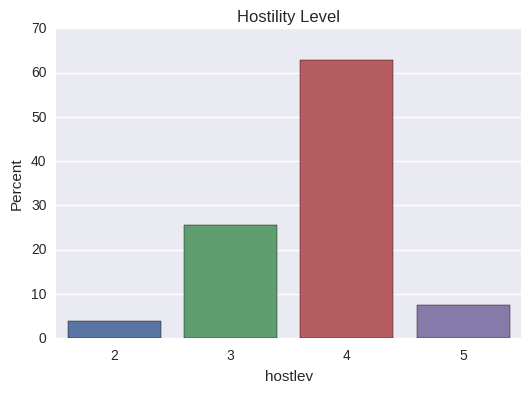

In [6]:
def percentplot(var, data, title=None):
    ax = sns.barplot(x=var, y=var, data=data, estimator=lambda x: len(x) * 100 / len(data))
    ax.set(ylabel="Percent")
    ax.set(title=title);

print(MID['hostlev'].value_counts(normalize=True))
percentplot('hostlev', MID, 'Hostility Level')

The ratio of diplomatic to military incidents varies over time. The 20th century was poor for diplomacy, but things have improved in the past decade.

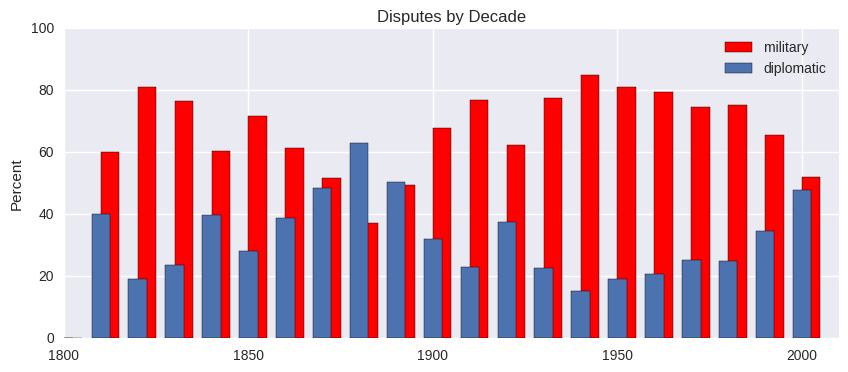

In [7]:
bins = range(1800, 2010, 10)
chunks = [MID[(MID.year>=year)&(MID.year<year+10)] for year in bins]
diplomatic = [0 if 0 == len(df) else len(df[df.hostlev<=3]) * 100 / len(df) for df in chunks]
military = [0 if 0 == len(df) else len(df[df.hostlev>=4]) * 100 / len(df) for df in chunks]

plt.figure(figsize=(10, 4))
plt.bar(bins, military, 5, color='red', label='military')
plt.bar(bins, diplomatic, 5, align='center', label='diplomatic')
plt.xlim(bins[0], bins[-1] + 10)
plt.ylim(0, 100)
plt.ylabel('Percent')
plt.title('Disputes by Decade')
plt.legend(loc='upper right')
plt.show()

I'm going to focus on the post WWII era, and we can see imbalance is similar.

4    0.664016
3    0.263917
5    0.041252
2    0.030815
Name: hostlev, dtype: float64


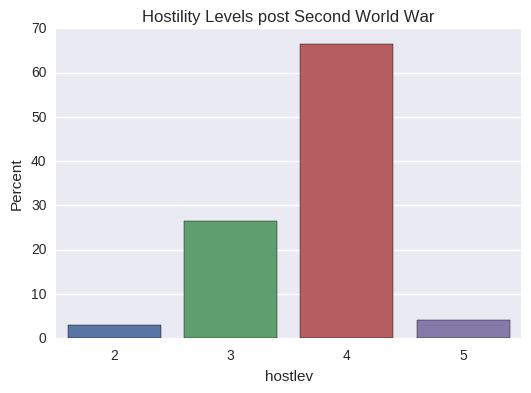

In [8]:
post_ww2 = MID[MID.year>=1950]
print(post_ww2['hostlev'].value_counts(normalize=True))
percentplot('hostlev', post_ww2, 'Hostility Levels post Second World War')

There is some small variation by month. This is interesting but maybe not meaningful.

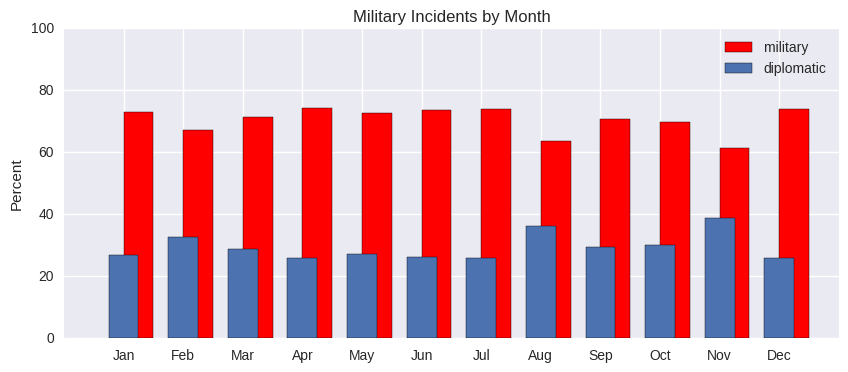

In [9]:
import calendar
bins = range(1, 13)
chunks = [MID[MID.month==x] for x in bins]
diplomatic = [0 if 0 == len(df) else len(df[df.hostlev<=3]) * 100 / len(df) for df in chunks]
military = [0 if 0 == len(df) else len(df[df.hostlev>=4]) * 100 / len(df) for df in chunks]

plt.figure(figsize=(10, 4))
plt.bar(bins, military, color='red', width=.5, label='military')
plt.bar(bins, diplomatic, align='center', width=.5, label='diplomatic')
plt.xlim(0, bins[-1] + 1)
plt.xticks(bins, [calendar.month_abbr[m] for m in bins])
plt.ylim(0, 100)
plt.ylabel('Percent')
plt.title('Military Incidents by Month')
plt.legend()
plt.show()

## Feature engineering
I engineer features with helper functions that each perform a specific operation.  
[[back to top]](#Sections)

#### Drop old

The first function drops old disputes from before 1950.

In [10]:
def drop_old(data):
    return data[data.year>=1950].copy()

#### Major powers

This function creates two columns indicating whether either side of the dispute was a major power. The data file [State System Membership](#Citations), imported into our database as MIDMAJ, describes which states were major powers and when.

In [11]:
majors_cache = None
def major_powers(data):
    # Convert MIDMAJ table to dictionary
    query = '''
        SELECT stabb, styear, endyear FROM  midmaj WHERE endyear >= 1950;
        '''
    global majors_cache
    if not majors_cache:
        majors_cache = pd.read_sql_query(query, cnx).set_index('stabb').to_dict(orient='index')
        assert majors_cache['USA'] == {'styear': 1898, 'endyear' : 2011} # data is through 2011

    majors = majors_cache;
    def is_major(row, col=None, dict_=None):
        """
        Given dataframe row, column name, and dictionary of major powers,
        return 0 or 1 indicating if the state was a major power.
        """
        result = 0
        abb = row[col]
        if abb and abb in dict_:
            year = row.year
            span = dict_[abb]
            # Make sure dispute is within state's span as major power
            if year >= span['styear'] and year <= span['endyear']:
                result = 1
        return result

    data['a_maj'] = data.apply(is_major, axis=1, col='a_abb', dict_=majors)
    data['b_maj'] = data.apply(is_major, axis=1, col='b_abb', dict_=majors)
    return data

#### Merge pairs

The MID data set lists each state on a separate row. This function merges these into one row for each pair of states. When only two states are involved, it collapses two rows to one. When three or more states are involved, it creates N x M rows where N and M are the number of states on either side.

In [12]:
def merge_pairs(data):
    d = OrderedDict()
    data.groupby('dispnum').apply(collect_pairs, dict_=d)
    result = pd.DataFrame.from_dict(d, orient='index').reset_index(drop=True)
    result.sort_values(by=['year', 'month', 'dispnum'], inplace=True)
    return result

def collect_pairs(group, dict_):
    """
    Collect N (side A) + M (side B) dispute rows into dictionary with
    N X M rows, one for each pair of states on opposite sides of the dispute.
    The function assumes rows are already grouped by dispute number.
    """
    dispnum = group.dispnum.iloc[0]
    for i in range(len(group)):
        state_a = group.a_abb.iloc[i]
        if not state_a:
            continue

        for j in range(len(group)):
            state_b = group.b_abb.iloc[j]
            if not state_b:
                continue

            # Dictionary key is tuple containing dispute
            # number, and state names ordered alphabetically

            swapped = False
            key = (dispnum, state_a, state_b)
            if state_b < state_a:
                key = (dispnum, state_b, state_a)
                swapped = True
            
            if not key in dict_:
                dict_[key] = OrderedDict()
    
            # Dictionary value is the dispute data
            # Get 'A' side and shared data from first 
            # state; get 'B' side data from second state.
            
            for col in group.columns:
                if col.startswith('b_'):
                    dict_[key][get_col(col, swapped)] = group[col].iloc[j]
                else:
                    dict_[key][get_col(col, swapped)] = group[col].iloc[i]
                    
def get_col(col, swapped=False):
    """
    Get column where to store a value. When 'swapped'
    is true, it exchanges the '_a' and '_b' columns.
    """
    if swapped:
        if col.startswith('a_'):
            return 'b_' + col[2:]
        elif col.startswith('b_'):
            return 'a_' + col[2:]
    return col

#### Prior disputes

This next function adds information about prior disputes. For each pair of states in a dispute it adds columns containing:

1. The total prior wins, yields and fatalities on both sides
2. The most common prior action by both sides
3. The total prior disputes of any kind

In [13]:
def prior_disputes(data):
    def priorsum(df, col):
        return df.groupby(['a_abb', 'b_abb'])[col].transform(pd.Series.cumsum) - df[col]
    
    def priormax(df, col):
        def _priormax(series):
            return pd.Series.cummax(series).shift(1).fillna(0)
        return df.groupby(['a_abb', 'b_abb'])[col].transform(_priormax)
    
    def priorcount(df, col):
        return df.groupby(['a_abb', 'b_abb'])[col].transform(lambda x: range(len(x)))
    
    def priormode(df, col):
        def _priormode(x):
            result = [0]
            c = Counter()
            for elem in x:
                c.update([elem])
                result.append(c.most_common()[0][0])
            return pd.Series(result)
        return df.groupby(['a_abb', 'b_abb'])[col].transform(_priormode)
    
    result = data.copy()
    for col in ['a_win', 'b_win', 'a_yield', 'b_yield', 'a_fatal', 'b_fatal']:
        result['p' + col] = priorsum(result, col)
        
    for col in ['a_hiact', 'b_hiact']:
        result['p' + col] = priormode(result, col)
        
    for col in ['dispnum', 'stalemate', 'compromise', 'released', 'unclear', 'joins_war']:
        result['p_' + col] = priorcount(result, col)
        
    assert result[(result.a_abb=='CHN')&(result.b_abb=='USA')]['p_dispnum'].iloc[-1] == 29
    assert result[(result.a_abb=='IND')&(result.b_abb=='PAK')]['p_dispnum'].iloc[-1] == 42
    return result

#### Power ratios

This function adds columns with the relative power of state B with respect to state A. It uses the [National Material Capabilities (v4.0)](#Citations) data set that contains the population and military capabilities of states over time. The NMC data set was imported into the database as MIDNMC.

In [14]:
nmc_cache = None
def power_ratios(data):
    # Convert NMC table to dictionary
    query = '''
        SELECT stabb, year, milexp, milpers, totalpop, urbanpop FROM MIDNMC WHERE year >= 1945;
        '''
    global nmc_cache
    if not nmc_cache:
        df_nmc = pd.read_sql_query(query, cnx)
        df_nmc.replace(-9, 0, inplace=True) # replace 'unknown' with zero
        nmc_cache = df_nmc.set_index(['stabb', 'year']).to_dict(orient='index')
    
    nmc_ = nmc_cache
    def get_ratio(row, item=None, dict_=None):
        """
        Given dataframe row and datapoint name, return the ratio of state B
        to state A.
        """
        result = np.nan
        a_val = get_value(row.a_abb, row.year, item, dict_)
        if a_val:
            b_val = get_value(row.b_abb, row.year, item, dict_)
            if b_val:
                result = b_val / a_val
        return result

    def get_value(stabb, year, item, dict_):
        """
        Get NMC value from dictionary. If no value is present for the
        requested year, check N=4 years before or after and return the
        first value found.
        """
        result = dict_.get((stabb, year), None)
        if not result:
            for i in range(1, 5):
                result = dict_.get((stabb, year - i), None)
                if not result:
                    result = dict_.get((stabb, year + i), None)
                if result:
                    break
        return result[item] if result else None
    
    result = data.copy()
    for col in ['milexp', 'milpers', 'totalpop', 'urbanpop']:
        result['r_' + col] = result.apply(get_ratio, axis=1, item=col, dict_=nmc_)
#        result['r_' + col].replace(np.nan, np.median(result['r_' + col].dropna()), inplace=True)

    return result

#### Contiguity

This function adds a column indicating how states border one another. It uses the [Direct Contiguity (v3.1)](#Citations) data set (in the MIDCONT database table) that registers the land and sea borders of all states since the Congress of Vienna (covering 1816-2006).

In [15]:
contiguity_cache = None
def contiguity(data):
    # Convert MIDCONT to dictionary. Because borders change, the
    # dictionary value is a time-stamped list.
    query = '''
        SELECT 
            statelab AS statea, statehab AS stateb,
            CAST(SUBSTRING(contbegin, 1, 4) AS integer) AS start, 
            CAST(SUBSTRING(contend, 1, 4) AS integer) AS end,
            CASE 
                WHEN conttype = 1 THEN 'Land'
                WHEN conttype = 2 THEN 'Water12'
                WHEN conttype = 3 THEN 'Water24'
                WHEN conttype = 4 THEN 'Water150'
                WHEN conttype = 5 THEN 'Water400'
            END AS conttype
        FROM 
            MIDCONT
        WHERE
            CAST(substring(contend, 1, 4) AS integer) >= 1950
        ORDER BY
            statelab, statehab
        '''
    global contiguity_cache
    if not contiguity_cache:
        cont = pd.read_sql_query(query, cnx)
        contiguity_cache = defaultdict(list)
        for r in cont.itertuples():
            contiguity_cache[(r.statea, r.stateb)].append((r.start, r.end, r.conttype))
    d =  contiguity_cache

    def get_contiguity(row, dict_=None):
        """
        Given dataframe row and contiguity dictionary, return the 
        contiguity between the corresponding two states.
        """
        result = 'None'
        list_ = dict_.get((row.a_abb, row.b_abb), None)
        if list_:
            for start, end, conttype in list_:
                if start <= row.year and end >= row.year:
                    result = conttype
        return result

    result = data.copy()
    result['contig'] = result.apply(get_contiguity, axis=1, dict_=d)
    return result

#### Build data set

Use the helper functions to build the model's dataset.

In [16]:
dataset = MID
dataset = drop_old(dataset)
dataset = major_powers(dataset)
dataset = merge_pairs(dataset)
dataset = prior_disputes(dataset)
dataset = power_ratios(dataset)
dataset = contiguity(dataset)

The data set contains 43 columns, including the target variable.

In [17]:
pp_dfinfo(dataset, 5)

2408 entries, 43 columns


## Modeling
[[back to top]](#Sections)

First, import standard tools and sklearn modules.

In [18]:
import patsy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing


Use a fixed random seed to ensure results are repeatable.

In [19]:
random_state = 4444

#### Helper functions

Define helper functions to assist with evaluating models, reporting, and plotting. This first one performs cross-validation on one or more models and returns performance statistics.

In [20]:
stats = OrderedDict([
    ('', 'Cross-validation score'),
    ('PPV', 'Diplomacy<br>Precision'),
    ('TPR', 'Diplomacy<br>Recall'),
    ('NPV', 'Military<br>Precision'),
    ('TNR', 'Military<br>Recall'),
    ('ACC', 'Accuracy')
    ])

def evaluate(models, X_train, y_train, X_test, y_test, stats=stats):
    headings = ['<b>{}</b>'.format(s) for s in stats.values()]
    d = OrderedDict({'' : headings})

    # Handle single model or list
    
    if not isinstance(models, list):
        models = [models]
    
    # Although cross_val_score uses StratifiedKFold automatically for
    # classification estimators, lets be explicit

    cv = model_selection.StratifiedKFold(n_splits=5, random_state=random_state)
    
    # Run models and collect stats
    
    for model in models:
        cv_scores = model_selection.cross_val_score(model, X_train, y_train, cv=cv)
        model.fit(X_train, y_train)
        cm = confusion_metrics(y_test, model.predict(X_test))
        scores = [round(np.mean(cv_scores), 3)] + [cm[stat] for stat in stats.keys() if stat]
        d[model.__class__.__name__] = scores
            
    return d

In [21]:
def confusion_metrics(y_true, y_pred):
    """
    Given the true and the predicted results from a model, 
    return a dictionary containing all confusion metrics.
    """
    def _div(a, b):
        return  round(a / b, 3) if b != 0 else 0.0
    
    d = OrderedDict()
    cm = metrics.confusion_matrix(y_true, y_pred)
    TP, FN = float(cm[0][0]), float(cm[0][1])
    FP, TN = float(cm[1][0]), float(cm[1][1])
    d['PPV'] = _div(TP, TP + FP) # postive predictive value (precision)
    d['TPR'] = _div(TP, TP + FN) # true positive rate (sensitivity, recall)
    d['NPV'] = _div(TN, TN + FN) # negative predictive value
    d['TNR'] = _div(TN, FP + TN) # true negative rate (specificty)
    d['FPR'] = _div(FP, FP + TN) # false postive rate (fall-out)
    d['FDR'] = _div(FP, FP + TP) # false discovery rate
    d['FNR'] = _div(FN, FN + TP) # false negative rate (miss rate)
    d['ACC'] = _div(TP + TN, TP + TN + FP + FN) # accuracy
    return d

This **```tune```** function uses ```GridSearchCV``` to tune a model. You pass it the type of model, the tuning parameters, the training and test sets, and the scoring method. It plots the confusion matrix, ROC and AUC, and returns the best parameters and corresponding statistics.

In [22]:
def tune(type_, params, X_train, y_train, X_test, y_test, scoring='recall'):
    model = type_()
    name_ = model.__class__.__name__

    # StratifiedKFold is the default, but let's be explicit
    cv = model_selection.StratifiedKFold(n_splits=5, random_state=random_state)
    gridSearch = model_selection.GridSearchCV(model, params, cv=cv, n_jobs=4,
                                              scoring='{}_macro'.format(scoring))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', '.*Precision is ill-defined')
        gridSearch.fit(X_train, y_train)

    model = type_(**gridSearch.best_params_)
    stats = evaluate(model, X_train, y_train, X_test, y_test)

    pp_dictOflist(stats)
    plot_performance(model, X_test, y_test)
    
    return stats, gridSearch.best_params_

In [23]:
def plot_performance(model, X_test, y_test):
    """
    Plot the confusion matrix, ROC and AUC for a model.
    """
    # Confusion matrix
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    cm = metrics.confusion_matrix(y_test, model.predict(X_test))
    plot_confusion_matrix(cm, classes=model.classes_, normalize=False);

    # ROC, AUC
    try:
        fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1], 
                                        pos_label=model.classes_[1])
    except AttributeError:
        fpr, tpr, _ = metrics.roc_curve(y_test, model.decision_function(X_test),
                                        pos_label=model.classes_[1])
    plt.subplot(122)
    plt.plot(fpr, tpr)
    auc = metrics.auc(fpr, tpr)
    plt.title('{0} AUC = {1:.2f}'.format(model.__class__.__name__, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()
    plt.show()
    

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix. Normalization can be 
    applied by setting normalize=True.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    xs = np.arange(len(classes))
    plt.xticks(xs, classes)
    plt.yticks(xs, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.max() * 3 / 4.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

This is a dumb predictor. It's used as a baseline for evaluating models. It always guesses the most common outcome in the training set. 

In [25]:
class Baseline(object):
    def __init__(self, guess=None):
        self.guess = guess
        
    def fit(self, X, Y):
        self.guess = Counter(Y).most_common(1)[0][0]
        pass
    
    def predict(self, X):
        pred = np.array([self.guess] * len(X))
        return pred        
    
    def score(self, X, Y):
        return metrics.accuracy_score(Y, self.predict(X))
    
    def get_params(self, deep=False):
        return {'guess': self.guess}

#### Prepare training data set

Drop null values.

In [26]:
df_model = dataset.copy()
df_model = df_model.dropna(how='any').reset_index(drop=True)
print(len(df_model))

1673


Create binary **Y** target.


In [27]:
df_model['target'] = df_model.hostlev.apply(lambda x: 'Diplomatic' if x < 4 else 'Military')

Convert 'highest action' to descriptive string

In [28]:
dispute_actions = {
    0 : 'None', 1 : 'ThreatForce', 2 : 'ThreatBlockade', 3 : 'ThreatOccupy', 
    4 : 'ThreatDeclareWar', 5 : 'ThreatUseCBR', 6 : 'ThreatJoinWar', 7 : 'ShowForce',
    8 : 'Alert', 9 : 'NuclearAlert', 10 : 'Mobilize', 11 : 'FortifyBorder',
    12 : 'ViolateBorder', 13 : 'Blockade', 14 : 'Occupy' , 15 : 'Seizure',
    16 : 'Attack', 17 : 'Clash', 18 : 'DeclareWar', 19 : 'UseCBR', 
    20 : 'BeginWar', 21 : 'JoinWar'
    }

df_model['pa_hiact_s'] = df_model.pa_hiact.apply(lambda x: dispute_actions[x])
df_model['pb_hiact_s'] = df_model.pb_hiact.apply(lambda x: dispute_actions[x])

Create dummies

In [29]:
X_pa_hiact = (
    patsy.dmatrix('pa_hiact_s', data=df_model, return_type='dataframe')
    .drop('Intercept', axis=1)
    )
X_pb_hiact = (
    patsy.dmatrix('pb_hiact_s', data=df_model, return_type='dataframe')
    .drop('Intercept', axis=1)
    )
X_contig = (
    patsy.dmatrix('contig', data=df_model, return_type='dataframe')
    .drop('Intercept', axis=1)
    )

Extract X's and y. Include everything for now.

In [30]:
all_features = [
    'numab',
    'a_maj', 'b_maj',
    'p_dispnum', 'pa_win', 'pb_win', 'pa_yield', 'pb_yield', 'pa_fatal', 'pb_fatal',
    'p_stalemate', 'p_compromise', 'p_released', 'p_unclear', 'p_joins_war',
    'r_milexp', 'r_milpers', 'r_totalpop', 'r_urbanpop'
]

X = df_model[all_features].copy().join([X_pa_hiact, X_pb_hiact, X_contig])
y = df_model['target'].copy()

Split data into training and test sets.

The target classes are imbalanced, so I stratify the folds to preserve the percentage of samples. This helper function checks the mix of targets.

In [31]:
def report_mix(X, y, name):
    target_mix = y.value_counts() / sum(y.value_counts())
    print('{} set: {:d} samples, target mix: {:.0%} / {:.0%}'.format(name, len(X), *target_mix))

In [32]:
TrainTestSplit = namedtuple('TrainTestSplit', 'X_train, X_test, y_train, y_test')
split_params = {'test_size' : .30, 'random_state' : random_state, 'stratify' : y}

In [33]:
# Create train/test split
train_test = TrainTestSplit(*model_selection.train_test_split(X, y, **split_params))

# Normalize values
normed = TrainTestSplit(
    preprocessing.normalize(train_test.X_train, axis=0, norm='max'),
    preprocessing.normalize(train_test.X_test, axis=0, norm='max'),
    train_test.y_train,
    train_test.y_test
)

X_train, X_test = normed.X_train, normed.X_test
y_train, y_test = train_test.y_train, train_test.y_test

In [34]:
report_mix(train_test.X_train, train_test.y_train, 'Train')
report_mix(train_test.X_test, train_test.y_test, 'Test')

Train set: 1171 samples, target mix: 68% / 32%
Test set: 502 samples, target mix: 68% / 32%


#### Try all algorithms

Here I try all classification algorithms to get a sense of how they compare.

When comparing algorithms, keep in mind that **Military recall** is important because we want to avoid military action and **Diplomacy precision** is also important because I want to know what bluffs are safe. You can see that ```LogisticRegression``` and ```SCV``` look promising. I also think ```KNN``` is interesting because the performance is better-balanced.

In [35]:
models = [
    Baseline(),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearSVC(random_state=random_state),
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    GaussianNB()
]

d = evaluate(models, X_train, y_train, X_test, y_test)    
pp_dictOflist(d)

,Cross-validation score,DiplomacyPrecision,DiplomacyRecall,MilitaryPrecision,MilitaryRecall,Accuracy
Baseline,0.677,0.0,0.0,0.677,1.0,0.677
KNeighborsClassifier,0.678,0.5,0.352,0.729,0.832,0.677
LogisticRegression,0.696,0.654,0.21,0.716,0.947,0.709
LinearSVC,0.683,0.614,0.216,0.715,0.935,0.703
SVC,0.677,0.0,0.0,0.677,1.0,0.677
DecisionTreeClassifier,0.667,0.439,0.488,0.742,0.703,0.633
RandomForestClassifier,0.676,0.504,0.438,0.748,0.794,0.679
GaussianNB,0.366,0.337,0.92,0.783,0.138,0.39


#### Tune hyperparameters

Above we saw how different the algorithms performed with no customizations. Now, I'll tune some of them. You can skip directly to the tuned results <a href='#tuned results'>here</a>. First, I set up a dictionary to collect the tuning results, then call **```tune```** for each classifier.

In [36]:
tuned = OrderedDict()

##### KNN

,Cross-validation score,DiplomacyPrecision,DiplomacyRecall,MilitaryPrecision,MilitaryRecall,Accuracy
KNeighborsClassifier,0.667,0.524,0.333,0.729,0.856,0.687


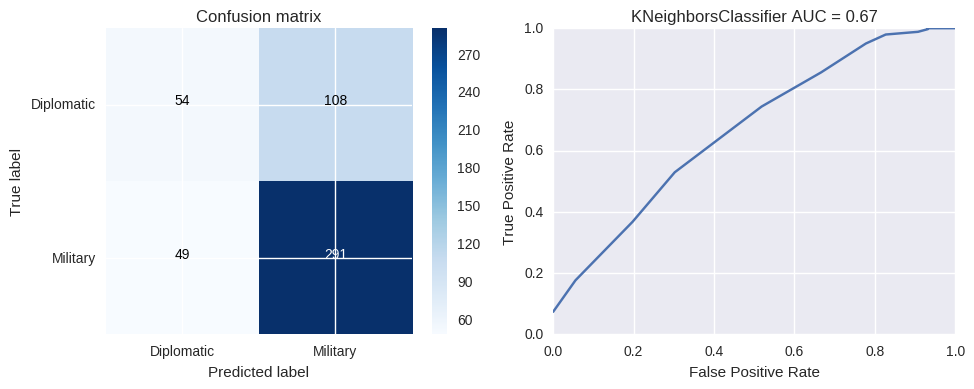

{'n_neighbors': 12}


In [37]:
knn_params = {
    'n_neighbors' : [x for a in range(1, 20, 2)]
}

perf, best_params = tune(KNeighborsClassifier, knn_params, X_train, y_train, X_test, y_test)
tuned.update(perf)
print(best_params)

##### Logistic regression

,Cross-validation score,DiplomacyPrecision,DiplomacyRecall,MilitaryPrecision,MilitaryRecall,Accuracy
LogisticRegression,0.682,0.583,0.259,0.721,0.912,0.701


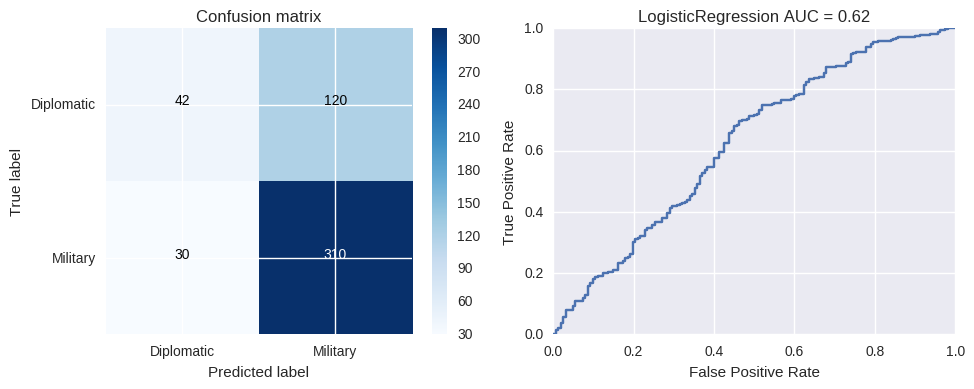

{'penalty': 'l2', 'C': 100, 'random_state': 4444}


In [38]:
lr_params = { 
    'random_state' : [random_state], 
    'penalty' : ['l1', 'l2'], 
    'C': [10 ** a for a in range(-6, 6)] 
}

perf, best_params = tune(LogisticRegression, lr_params, X_train, y_train, X_test, y_test)
tuned.update(perf)
print(best_params)

##### LinearSVC

,Cross-validation score,DiplomacyPrecision,DiplomacyRecall,MilitaryPrecision,MilitaryRecall,Accuracy
LinearSVC,0.682,0.587,0.228,0.715,0.924,0.699


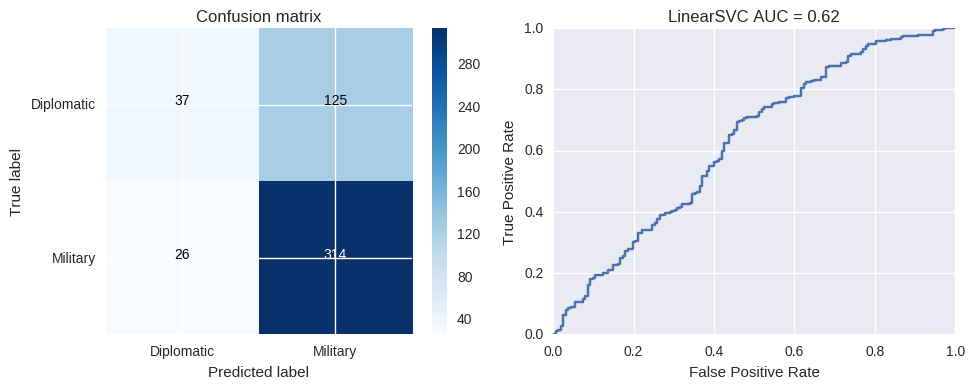

{'penalty': 'l2', 'C': 10, 'random_state': 4444, 'dual': False}


In [39]:
svc_params = [
    { 
        'random_state' : [random_state],
        'dual' : [False],
        'penalty' : ['l1', 'l2'],
        'C': [10 ** x for x in range(-6, 6)]
    },
    { 
        'random_state' : [random_state], 
        'dual' : [True],
        'C': [10 ** x for x in range(-6, 6)]
    }
]

perf, best_params = tune(LinearSVC, svc_params, X_train, y_train, X_test, y_test)
tuned.update(perf)
print(best_params)

##### Random forest

,Cross-validation score,DiplomacyPrecision,DiplomacyRecall,MilitaryPrecision,MilitaryRecall,Accuracy
RandomForestClassifier,0.732,0.624,0.327,0.739,0.906,0.719


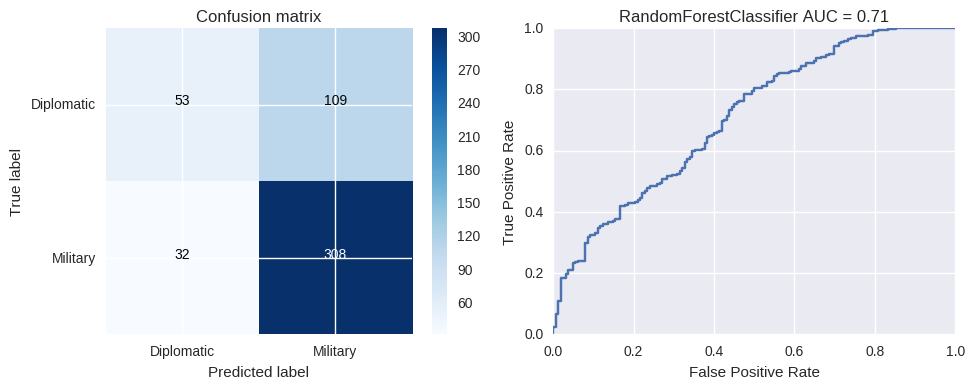

{'min_samples_split': 8, 'n_estimators': 100, 'random_state': 4444, 'criterion': 'gini', 'min_samples_leaf': 1}


In [40]:
rfc_params = { 
    'random_state' : [random_state],
    'criterion' : ['gini', 'entropy'], 
    'min_samples_leaf' : [1, 5, 10], 
    'min_samples_split' : [2**i for i in range(1, 7)], 
    'n_estimators': [10, 20, 50, 100]
}

perf, best_params = tune(RandomForestClassifier, rfc_params, X_train, y_train, X_test, y_test)
tuned.update(perf)
print(best_params)

<a id='tuned results'></a>
Here are the tuning results. Compare these with the untuned results from [above](#Try-all-algorithms).

In [41]:
pp_dictOflist(tuned)

,Cross-validation score,DiplomacyPrecision,DiplomacyRecall,MilitaryPrecision,MilitaryRecall,Accuracy
KNeighborsClassifier,0.667,0.524,0.333,0.729,0.856,0.687
LogisticRegression,0.682,0.583,0.259,0.721,0.912,0.701
LinearSVC,0.682,0.587,0.228,0.715,0.924,0.699
RandomForestClassifier,0.732,0.624,0.327,0.739,0.906,0.719


#### The final model

After more testing and evaluation, which I won't repeat here, I settled on  **random forest** as the best solution. I tried different kinds and combinations of features to see which produced the best results and settled on these you see below.
 
Of note,  the prior wins, yields and fatalies contributed positively to the model, but the other prior information did not. Also, it worked better to combine these priors into a single sum. The 'major power' feature also worked better as a combined sum.

Finally, I tuned the model one last time. Altogether it uses 37 features, of which all but nine are dummies.



In [42]:
features = [
    'numab', 'r_milexp', 'r_milpers', 'r_totalpop', 'r_urbanpop'
]

y = df_model['target'].copy()
X = df_model[features].copy().join([X_pa_hiact, X_pb_hiact, X_contig])

# Combine previous wins, yields and fatalies into single sum

for col in ['win', 'yield', 'fatal']:
    X['p_' + col] = df_model['pa_' + col] + df_model['pb_' + col]

# Combine 'major power' into single sum

X['maj'] = df_model['a_maj'] + df_model['b_maj']

In [43]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, **split_params)

In [44]:
params = {
    'min_samples_split': 2, 
    'n_estimators': 10, 
    'random_state': 4444, 
    'criterion': 'entropy', 
    'min_samples_leaf': 1
}

rfc = RandomForestClassifier(**params)

,Cross-validation score,DiplomacyPrecision,DiplomacyRecall,MilitaryPrecision,MilitaryRecall,Accuracy
RandomForestClassifier,0.699,0.575,0.475,0.769,0.832,0.717


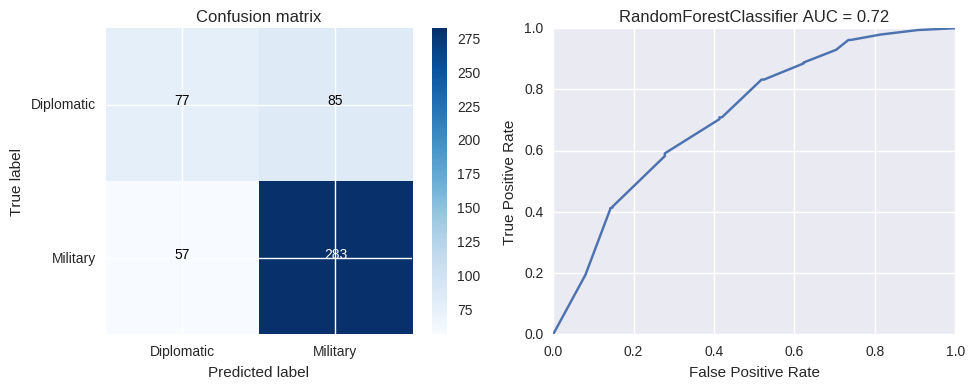

In [45]:
pp_dictOflist(evaluate(rfc, X_train, y_train, X_test, y_test))
plot_performance(rfc, X_test, y_test)

####  Top features

The model found all the "power ratio" features significant; with relative military expenditures, urban population and military personnel the top three. After that comes whether the states **don't** share a border, and whether one state previously attacked the other.

In [46]:
features = [(name, rfc.feature_importances_[i]) for i, name in enumerate(X_train.columns)]
features.sort(key=lambda x: x[1], reverse=True)
pp_dict({x[0] : '{:.3f}'.format(x[1]) for x in features[:10]})

r_milexp,0.141
r_urbanpop,0.146
r_milpers,0.155
contig[T.None],0.022
pa_hiact_s[T.Attack],0.014
r_totalpop,0.143
numab,0.122
maj,0.030
p_fatal,0.064
p_win,0.018


#### Save the model

Here I save the model and supporting data for the predictor app. I use .CSV when possible because I think it's good to have data in a human-readable form, especially when space or performance is not an issue.

In [47]:
import pickle
from sklearn.externals import joblib

In [48]:
joblib.dump(rfc, 'MID_predictor.pkl');

In [49]:
df_model.to_csv('MID_predictor_observations.csv', index=False)
X_test.iloc[-1:].to_csv('MID_predictor_X.csv', index=False)

In [50]:
df = pd.DataFrame.from_dict(majors_cache, orient='index').reset_index()
df.rename(columns={'index' : 'stabb'}, inplace=True)
df.to_csv('MID_predictor_majors.csv', index=False)

In [51]:
df = pd.DataFrame.from_dict(nmc_cache, orient='index').reset_index()
df.rename(columns={'level_0' : 'stabb', 'level_1' : 'year'}, inplace=True)
df.to_csv('MID_predictor_nmc.csv', index=False)

In [52]:
l_ = []
for k, v in contiguity_cache.items():
    l_.extend(list(k) + list(value) for value in v)
df = pd.DataFrame(l_)
df.columns = ['statea', 'stateb', 'start', 'end', 'conttype']
df.to_csv('MID_predictor_contiguity.csv', index=False)

## Citations
[[back to top]](#Sections)

The following data sets were utilized in this project:

</a href='MID41'>**Militarized Interstate Disputes (v4.1)**  
*Palmer, Glenn, Vito D'Orazio, Michael Kenwick, and Matthew Lane.  2015.  "The MID4 Data Set: Procedures, Coding Rules, and Description."  Conflict Management and Peace Science.  Forthcoming.*

**State System Membership**  
*Correlates of War Project. 2011. "State System Membership List, v2011." Online, http://correlatesofwar.org*

**National Material Capabilities (v4.0)**  
*Singer, J. David, Stuart Bremer, and John Stuckey. (1972). "Capability Distribution, Uncertainty, and Major Power War, 1820-1965." in Bruce Russett (ed) Peace, War, and Numbers, Beverly Hills: Sage, 19-48.*

*Singer, J. David. 1987. "Reconstructing the Correlates of War Dataset on Material Capabilities of States, 1816-1985" International Interactions, 14: 115-32.*

**Direct Contiguity (v3.1)**  
*Correlates of War Project. Direct Contiguity Data, 1816-2006. Version 3.1. Online: http://correlatesofwar.org.*

**MID Location, 1816-2001 (v1.1)**  
*Braithwaite, Alex. 2010. “MIDLOC: Introducing the Militarized Interstate Dispute (MID) Location Dataset.” Journal of Peace Research 47: 91-98.*

## Scratchpad
[[back to top]](#Sections)

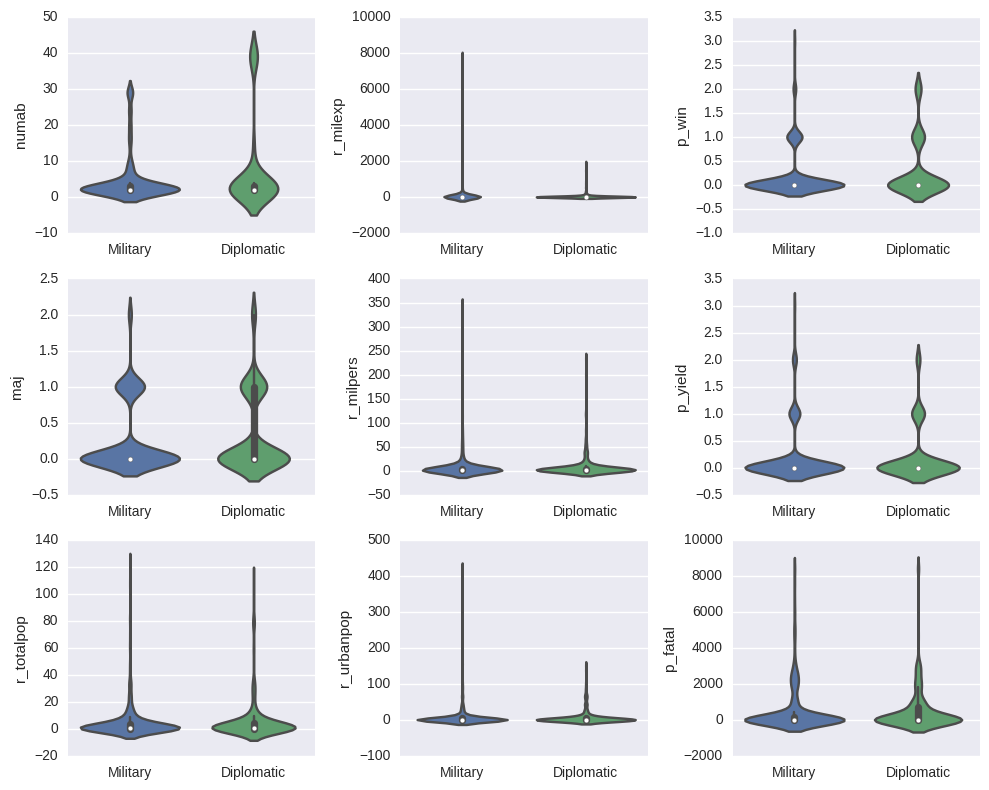

In [53]:
columns = [
    'numab', 'r_milexp', 'p_win',
    'maj', 'r_milpers', 'p_yield',
    'r_totalpop', 'r_urbanpop', 'p_fatal'
    ]

df = X.copy()
df['target'] = y

plt.figure(figsize=(10, 8))
for i, col in enumerate(columns):
    plt.subplot(331 + i)
    ax = sns.violinplot(x='target', y=col, data=df)
    ax.set_xlabel('')
plt.tight_layout()
plt.show()